# NOTEBOOK 6b: ANALISI COUNTERFACTUALS


- fare (df con y_min, y_white, differenza e poi) media differenza per tutti i modelli  

In [1]:
# IMPORTING STATEMENTS
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


np.random.seed(7)


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.1.1
Scikit-Learn 1.3.1
GPU is available


# Import Data and Preparation

In [2]:
# DF FINALE 

counterf = pd.read_csv('TEST_DATA.csv')

In [3]:
# Import Predictions
path = 'predictions/'    # path of folder

In [4]:
models = ['LinearRegression', 'RandomForest', 'XGBoost', 'LightGBM','HybridModel','Stacking']
y_preds = []

for model in models:
    y_preds.append( pd.read_csv(str(path)+str(model)+'_pred.csv', header=None).loc[:,0])

In [5]:
y_preds[0]

0      -3.222800e+09
1      -3.222800e+09
2      -3.222800e+09
3      -3.222800e+09
4      -3.222800e+09
            ...     
4495    3.781332e+00
4496    2.888615e+00
4497    3.478479e+00
4498    2.284192e+00
4499    2.891445e+00
Name: 0, Length: 4500, dtype: float64

In [6]:
counterf.reset_index(drop=True, inplace=True)

In [7]:
y_true = counterf.pop('InterestRate') 

In [8]:
y_true

0       4.500
1       5.000
2       2.625
3       3.625
4       3.750
        ...  
4495    4.000
4496    2.875
4497    3.000
4498    2.750
4499    2.875
Name: InterestRate, Length: 4500, dtype: float64

In [9]:
idx_min = counterf[counterf['Minority_Min']==1].index
idx_miss = counterf[counterf['Minority_Missing']==1].index
idx_white = counterf[counterf['Minority_White']==1].index

# PLOT RESULTS: MODIFICARE!!!

In [10]:
models

['LinearRegression',
 'RandomForest',
 'XGBoost',
 'LightGBM',
 'HybridModel',
 'Stacking']

In [11]:
colors_true=['DarkRed','DarkBlue', 'DarkGreen']
colors=['Crimson', 'DodgerBlue', 'Green']
titles=['Minority','White','Missing']
indices=[idx_min, idx_white, idx_miss]

In [12]:
def create_subplots(models, y_preds, y_true, indices, colors, colors_true, titles):
    for j, model in enumerate(models):
        y_pred = y_preds[j]

        plt.figure(figsize=(8, 7))
        plt.suptitle(model)

        # Create plot
        for i, idx in enumerate(indices):
                        
            # Select, sort the data and get the sorted indices
            y_pred_sel, y_true_sel = y_pred[idx], y_true[idx]
            sorted_indices = np.argsort(y_true_sel)

            # Sort y_true and y_pred based on the sorted indices
            y_true_sorted = np.array(y_true_sel)[sorted_indices]
            y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

            # Create a scatterplot
            plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=0.5, s=4)
        if i==len(indices)-1:
            plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='True Value', alpha=1, s=3)
            plt.xlabel('Sorted Index')
            plt.ylabel('Interest Rate')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.tight_layout()

        plt.show();
        plt.clf()
        

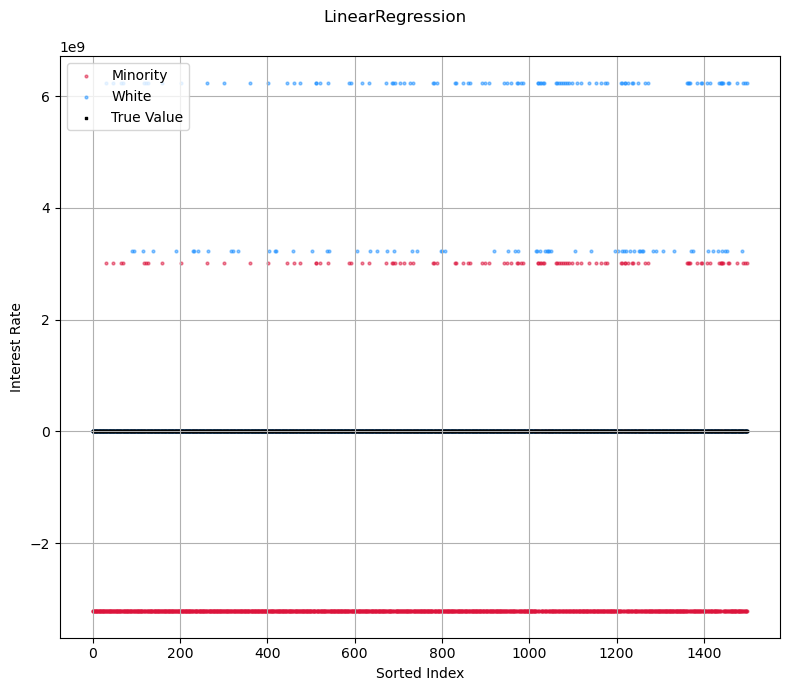

<Figure size 640x480 with 0 Axes>

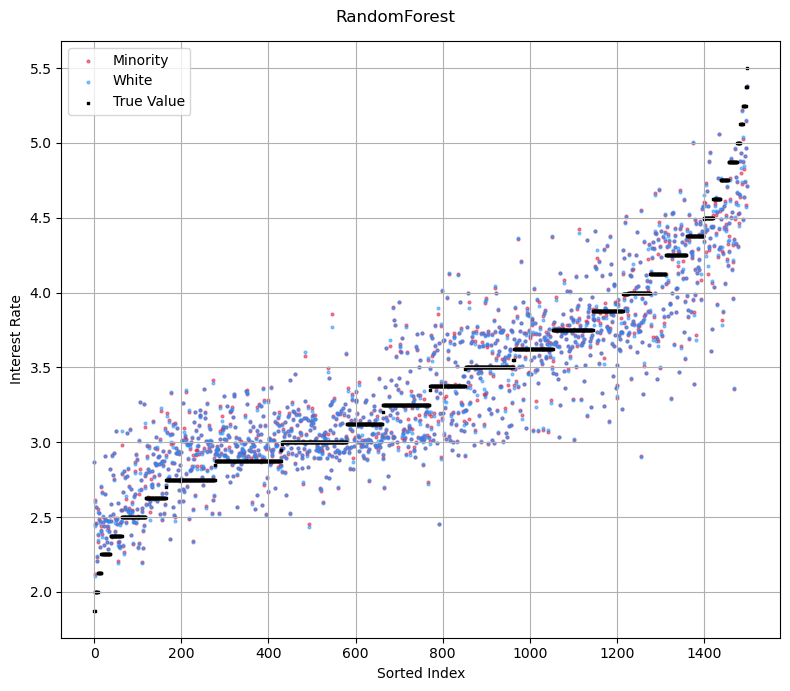

<Figure size 640x480 with 0 Axes>

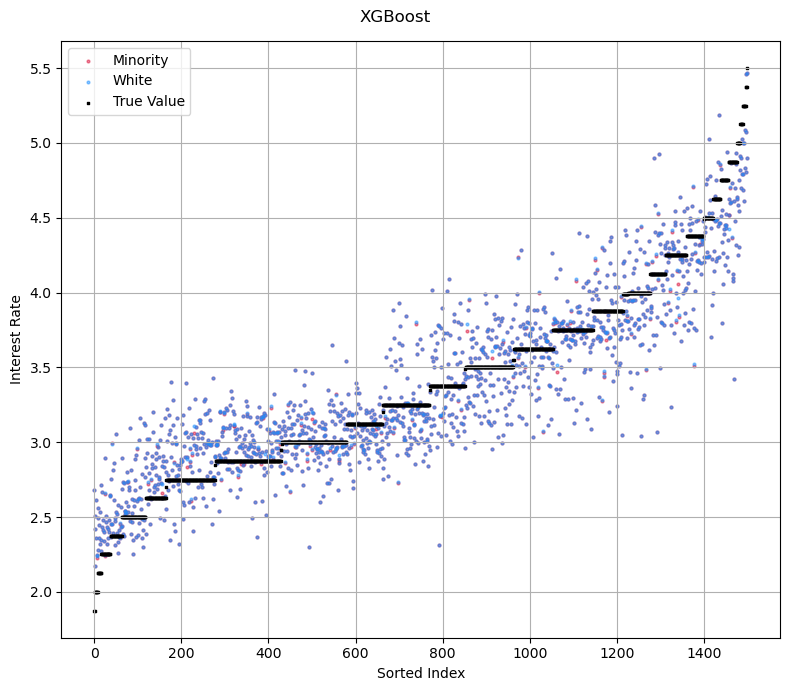

<Figure size 640x480 with 0 Axes>

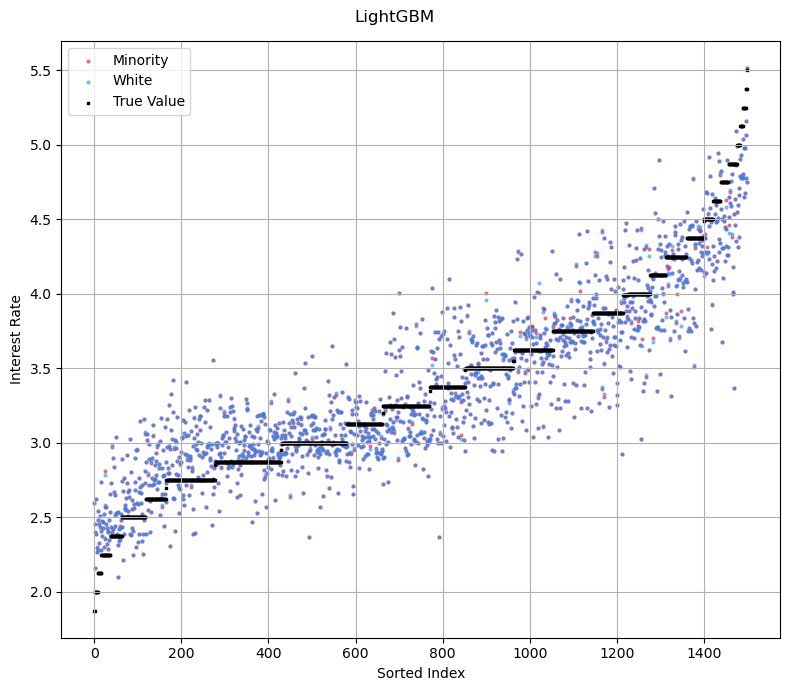

<Figure size 640x480 with 0 Axes>

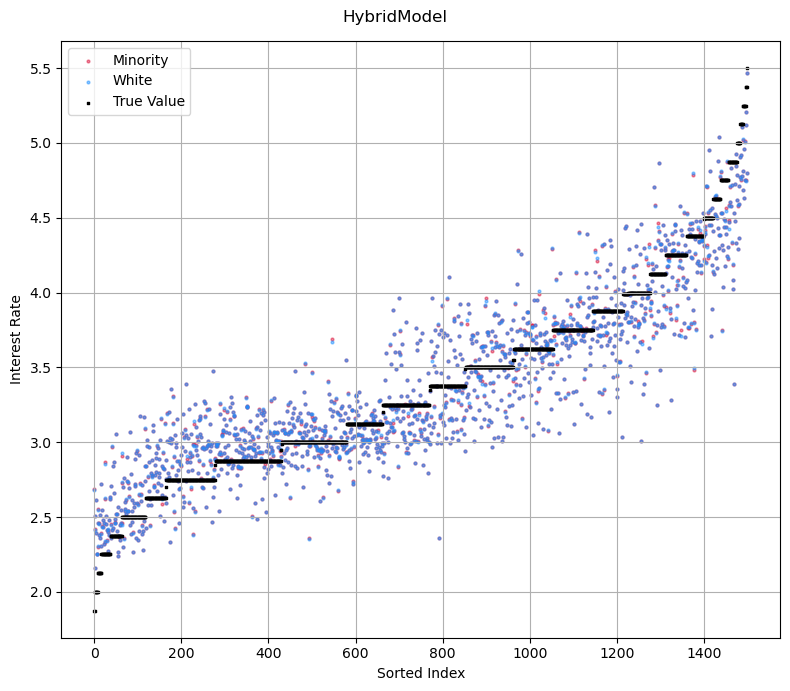

<Figure size 640x480 with 0 Axes>

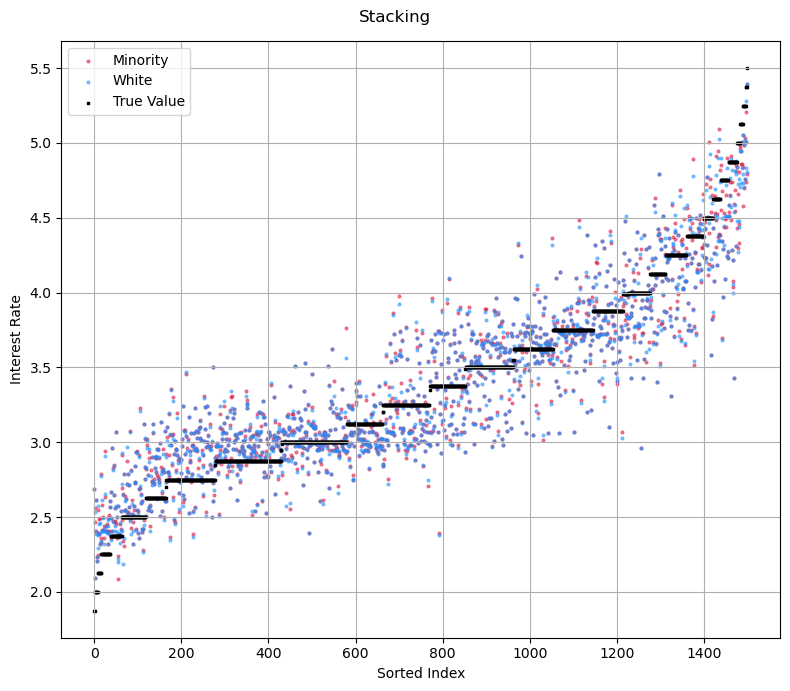

<Figure size 640x480 with 0 Axes>

In [13]:
create_subplots(models, y_preds, y_true, indices[:-1], colors, colors_true, titles)

For stacking, it is possible to identify some points that have higher interest rate predictions for minority applicants than for white applicants. This is especially true for the middle-high range of interest rates, suggesting that ethnicity plays a bigger role when the applicant is already belonging to a higher-risk category because of other factors than minority status.
At the same time, this trend is not always consistent, so no conclusions can be made.

### fare (df con y_min, y_white, differenza e poi) media differenza per tutti i modelli

In [14]:
import numpy as np
import pandas as pd
from scipy import stats

avg_diffs, ttests = [], []
diffs, t_statistic, p_value, pair, names = [], [], [], [], []

for i, model in enumerate(models):
    #print(model)
    y_pred = y_preds[i]
    avg_diffs.append([
        np.mean(np.array(y_pred[idx_min]) - np.array(y_pred[idx_white])),
        np.mean(np.array(y_pred[idx_min]) - np.array(y_pred[idx_miss])),
        np.mean(np.array(y_pred[idx_miss]) - np.array(y_pred[idx_white])),
        model ])
    
    # Perform t-tests
    for j in range(len(indices)):
        for k in range(j + 1, len(indices)):
            #print(j,k)
            diff = np.mean(np.array(y_pred[indices[j]]) - np.array(y_pred[indices[k]]))
            t_stat, p_val = stats.ttest_ind(y_pred[indices[j]], y_pred[indices[k]])
            t_statistic.append(t_stat)
            p_value.append(p_val)
            pair.append(str(titles[j])+'-'+str(titles[k]))
            names.append(model)
            diffs.append(diff)
    #ttests.append( [t_statistic, p_value, pair, [model]*3])

# Create a DataFrame for the average differences
avg_diffs_df = pd.DataFrame(avg_diffs, columns=['AvgDiff_Min_White', 'AvgDiff_Min_Miss', 'AvgDiff_Miss_White', 'Model'])
ttest_diffs_df = pd.DataFrame([diffs, t_statistic, p_value, pair, names], index=['Difference','t_statistic', 'p_value', 'Pair', 'Model'])#, columns=['T_Min_White', 'T_Min_Miss', 'T_Miss_White', 'Model'])


In [15]:
# Display the DataFrame
pd.options.display.float_format = '{:.6f}'.format

avg_diffs_df#['AvgDiff_Min_White'].apply(lambda x: '%.6f' % x)

,AvgDiff_Min_White,AvgDiff_Min_Miss,AvgDiff_Miss_White,Model
0,-3222799750.795904,3021896685.006815,-6244696435.802719,LinearRegression
1,0.001989,0.000537,0.001452,RandomForest
2,-0.000840,-0.000840,0.000000,XGBoost
3,0.000008,0.000008,0.000000,LightGBM
4,0.000065,-0.000225,0.000290,HybridModel
5,0.002250,0.001506,0.000744,Stacking


In [16]:
results = ttest_diffs_df.T

In [17]:
import helper_functions_fs as hf

def format_df_green(s, green_value=0.05):
    if type(s)==str: color = 'white'
    else:
        if s <= green_value: color = 'lightgreen'
        else: color = 'white'
    return 'background-color: %s' % color 

In [18]:
results.style.applymap(format_df_green)

/var/folders/p_/77946ggd5fs5m05m058z3hp40000gn/T/ipykernel_79236/843840761.py:1: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  results.style.applymap(format_df_green)


,Difference,t_statistic,p_value,Pair,Model
0,-3222799750.795904,-52.799793,0.000000,Minority-White,LinearRegression
1,3021896685.006815,49.508357,0.000000,Minority-Missing,LinearRegression
2,6244696435.802719,102.308150,0.000000,White-Missing,LinearRegression
3,0.001989,0.093451,0.925551,Minority-White,RandomForest
4,0.000537,0.025245,0.979862,Minority-Missing,RandomForest
5,-0.001452,-0.068204,0.945628,White-Missing,RandomForest
6,-0.000840,-0.039117,0.968800,Minority-White,XGBoost
7,-0.000840,-0.039117,0.968800,Minority-Missing,XGBoost
8,0.000000,0.000000,1.000000,White-Missing,XGBoost
9,0.000008,0.000354,0.999717,Minority-White,LightGBM


# old graphs

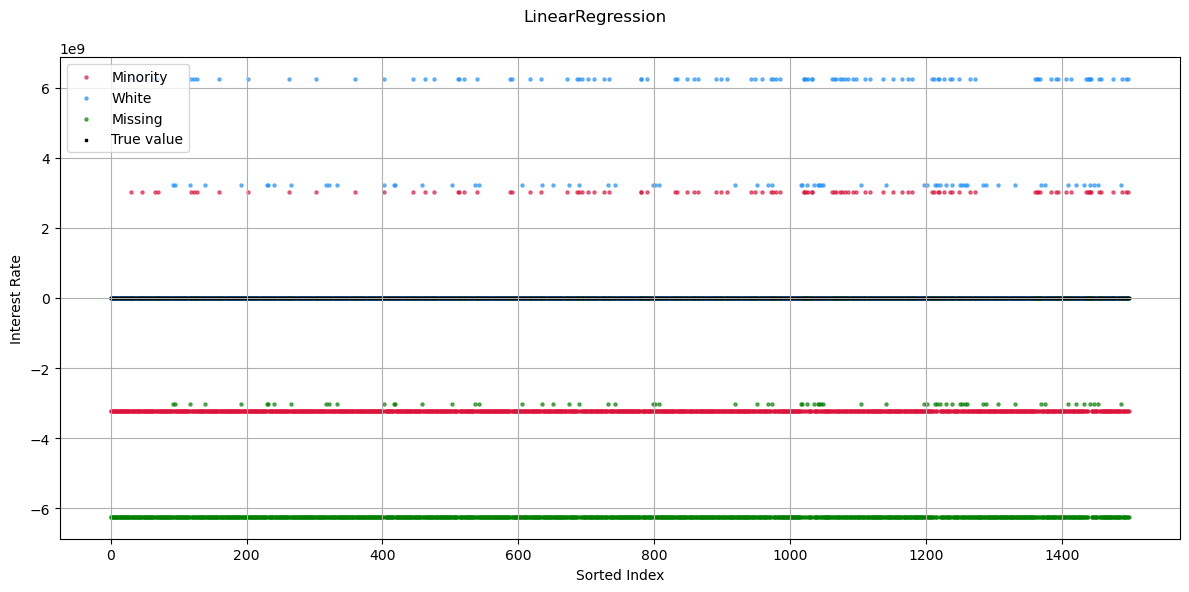

<Figure size 640x480 with 0 Axes>

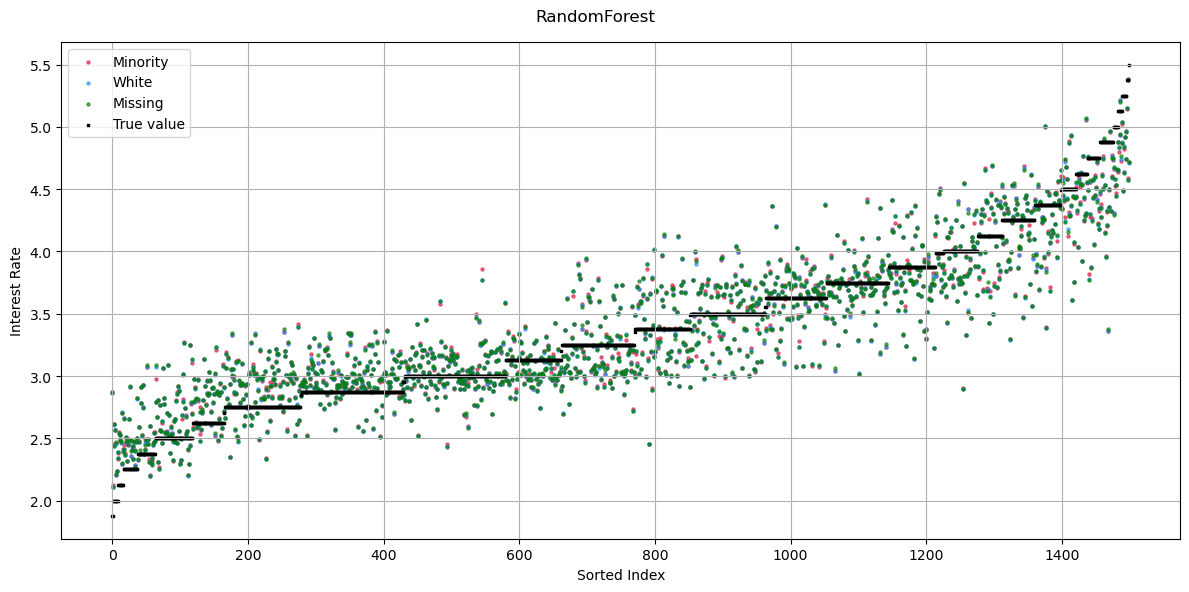

<Figure size 640x480 with 0 Axes>

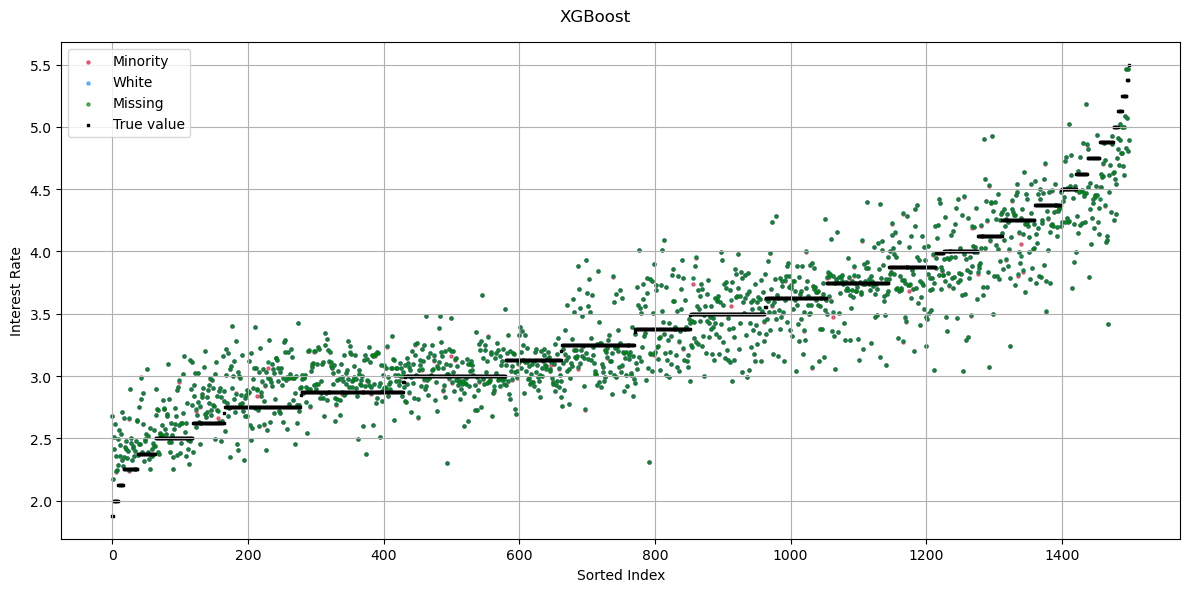

<Figure size 640x480 with 0 Axes>

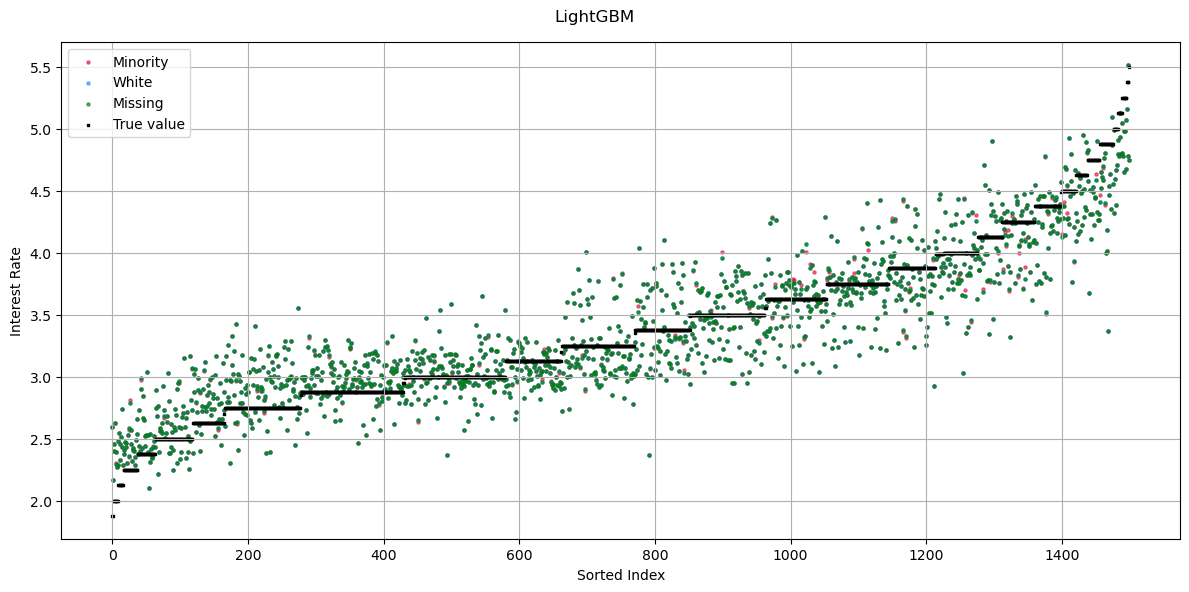

<Figure size 640x480 with 0 Axes>

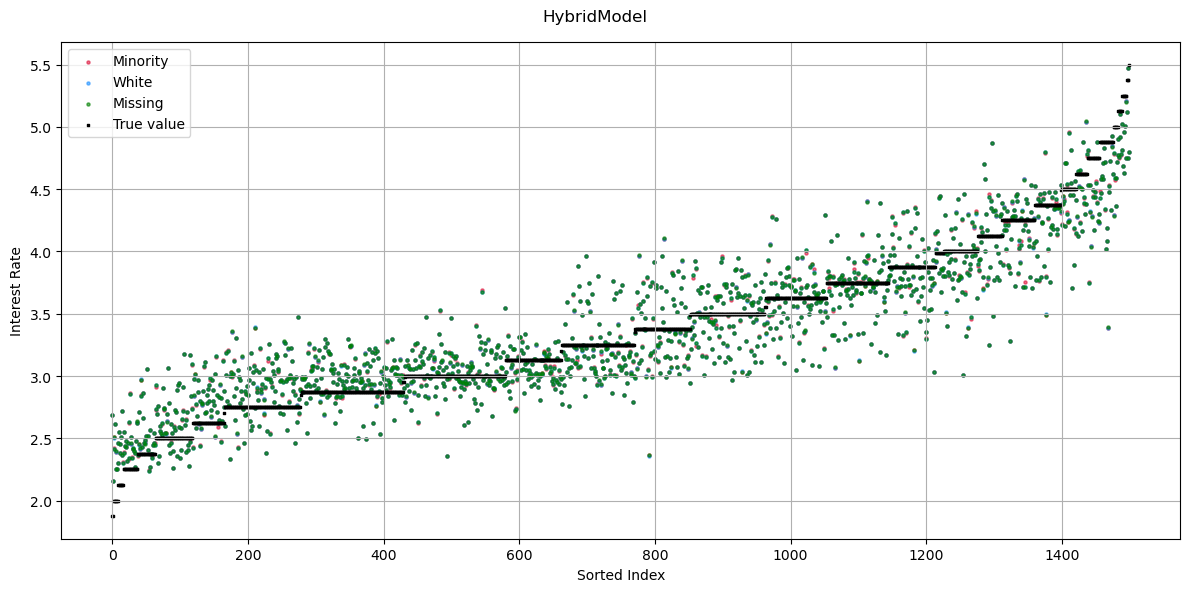

<Figure size 640x480 with 0 Axes>

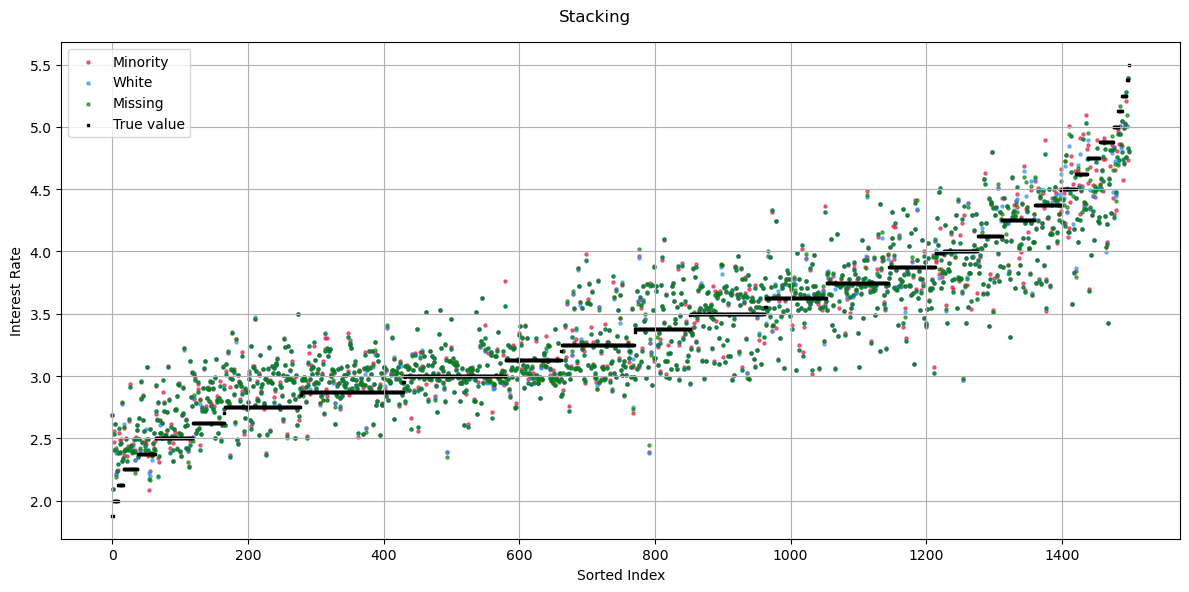

<Figure size 640x480 with 0 Axes>

In [20]:
for j, model in enumerate(models):
    y_pred = y_preds[j]
    
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(model)

    # Create three subplots in a 1x3 grid
    for i, idx in enumerate(indices):
    
        y_pred_sel, y_true_sel = y_pred[idx], y_true[idx]

        # Sort the data and get the sorted indices
        sorted_indices = np.argsort(y_true_sel)

        # Sort y_true and y_pred based on the sorted indices
        y_true_sorted = np.array(y_true_sel)[sorted_indices]
        y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

        # Create a scatterplot
        plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=0.6, s=5)
        if i==2:
            plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='True value', alpha=1, s=3)
        plt.xlabel('Sorted Index')
        plt.ylabel('Interest Rate')
        #plt.title(titles[i])
        plt.legend(loc='upper left' )
        plt.grid(True)
        plt.tight_layout()

    plt.show()
    plt.clf()

0
1


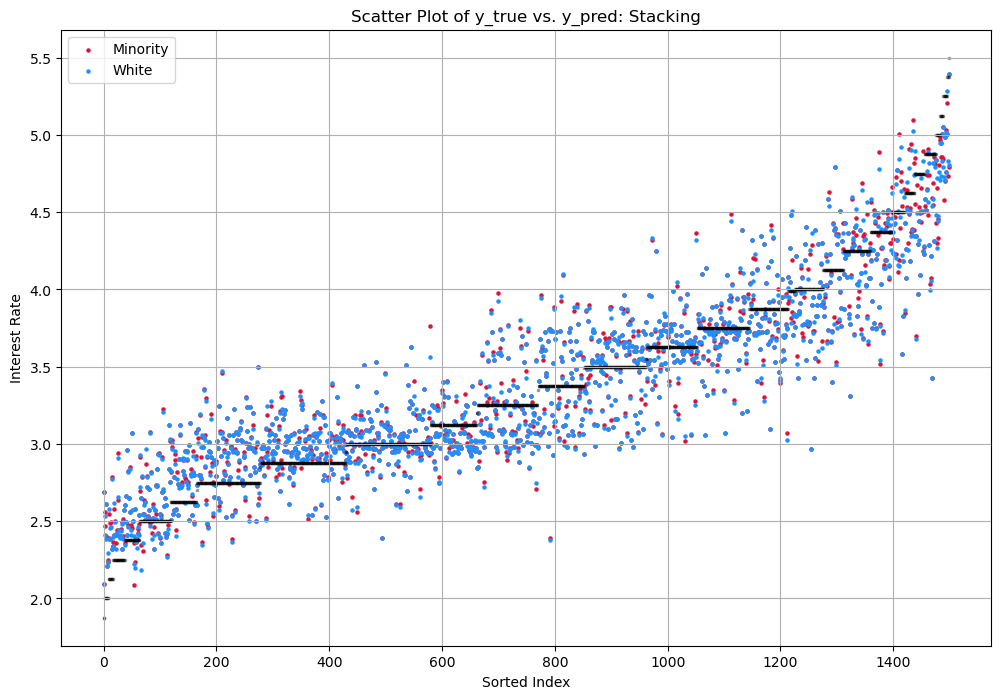

In [21]:
# VECCHIO !!!!
plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices[:-1]):    #idx_miss, 
    print(i)
    y_pred_sel, y_true_sel = y_pred[idx] , y_true[idx]
    
    # Sort the data and get the sorted indices
    sorted_indices = np.argsort(y_true_sel)

    # Sort y_true and y_pred based on the sorted indices
    y_true_sorted = np.array(y_true_sel)[sorted_indices]
    y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

    # Create a scatterplot
    plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=1, s=5)
    
    plt.xlabel('Sorted Index')
    plt.ylabel('Interest Rate')
    plt.title('Scatter Plot of y_true vs. y_pred: '+ model)
    plt.legend()

# plot y_true    
plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='y_true', alpha=0.3, s=3)    
# Show the plot
plt.grid(True)
plt.show()